In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/My Drive/SiameseNetwork_QA")
basePath = '/content/drive/My Drive/SiameseNetwork_QA/'

## Model
Siamese Recurrent Architectures for Learning Sentence Similarity (2016, AAAI)

![Architecture](https://drive.google.com/uc?export=view&id=1Vkvg2n0V4sFCxFtwxoMI5rXuSiUR3mpT)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Learn the Quora Dataset

### Main goal
to identify duplicate questions

### Task Background 
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. 


### Quora dataset: data fields
We are given a minimal number of data fields here, consisting of:

- id: Looks like a simple rowID
- qid{1, 2}: The unique ID of each question in the pair
- question{1, 2}: The actual textual contents of the questions.
- is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.


In [ ]:
df_train = pd.read_csv(basePath + 'data/quora_train.csv')
df_train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [ ]:
print(f" An example pair of duplicates:\n") 
print("Question 1: " + df_train.loc[7, "question1"])
print(f"Question 2: " + df_train.loc[7, "question2"])

 An example pair of duplicates:

Question 1: How can I be a good geologist?
Question 2: What should I do to be a great geologist?


In [ ]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of unique questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of unique questions in the training data: 537933
Number of questions that appear multiple times: 111780


In [ ]:
df_test = pd.read_csv(basePath + 'data/quora_test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [ ]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796


mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


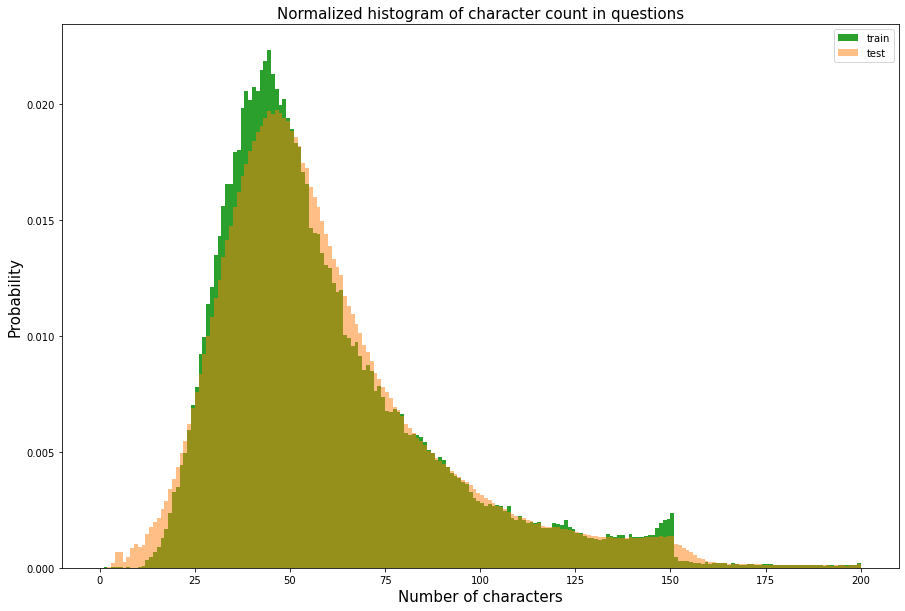

In [ ]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
# normalized hist: s.t. areas sum is 1.
plt.hist(dist_train, bins=200, range=[0, 200], density= True, color=pal[2], label='train') 
plt.hist(dist_test, bins=200, range=[0, 200], density = True, color=pal[1], alpha=0.5, label='test')
plt.title('Normalized histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


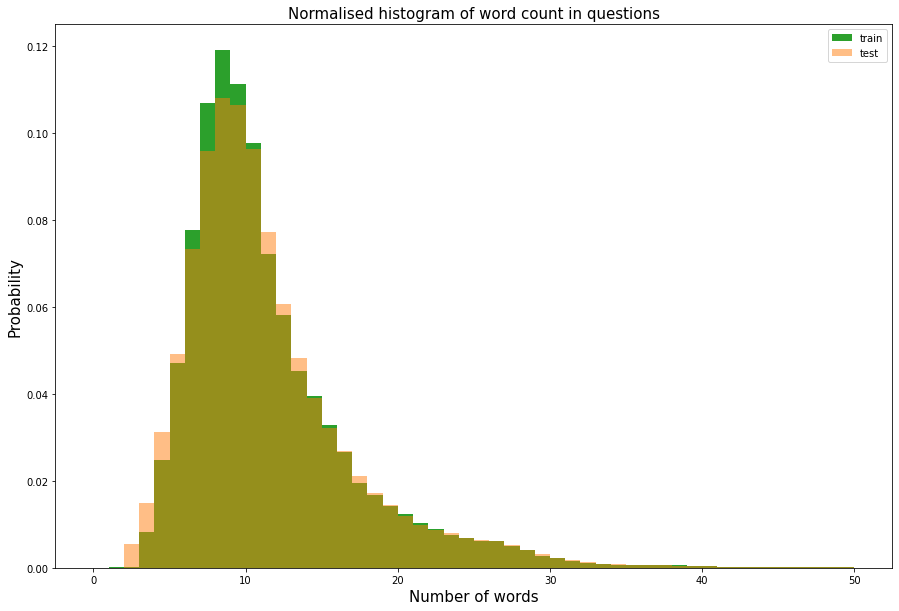

In [ ]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], density=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

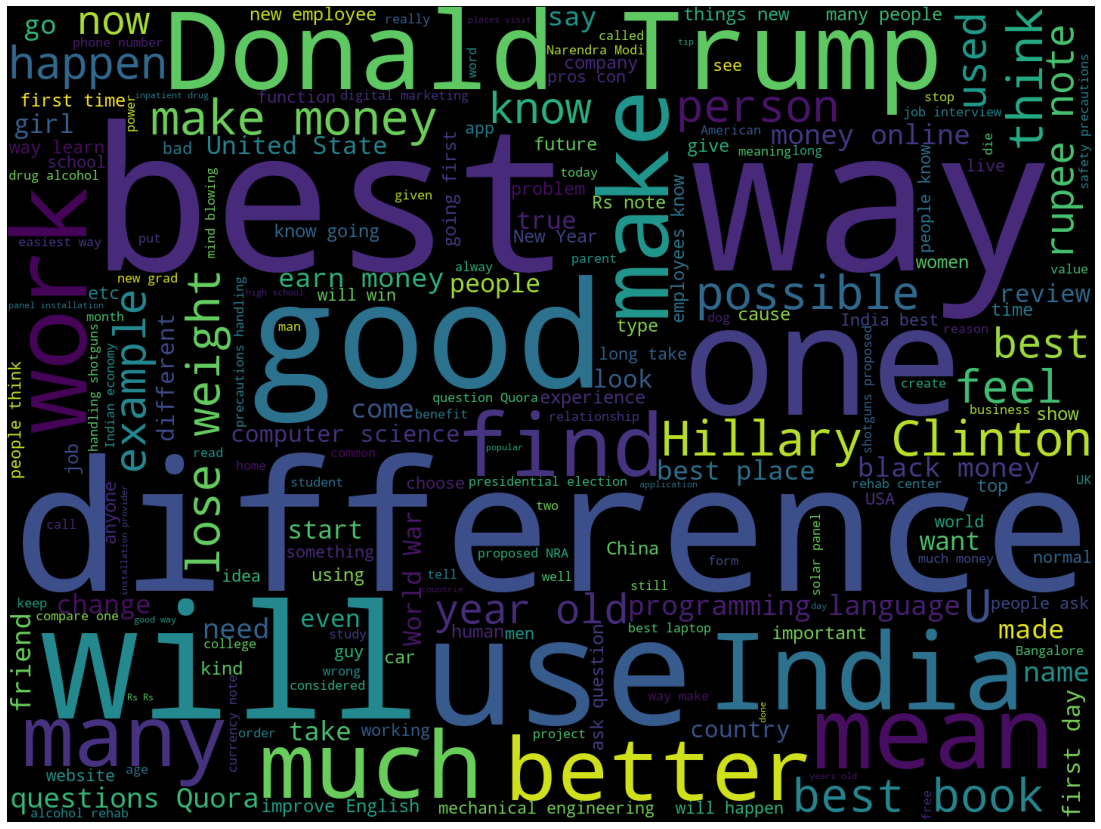

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')


## Model

Siamese Recurrent Architectures for Learning Sentence Similarity (2016, AAAI)

![Architecture](https://drive.google.com/uc?export=view&id=1Vkvg2n0V4sFCxFtwxoMI5rXuSiUR3mpT)

- We pass in two questions. Feed them into the LSTM subnetwork(practically, there is only one) and the final state of the LSTM for each question is a vector. It is trained to capture semantic meaning of the question. We then put these two vectors through the defined similarity function which is ranged between 0 and 1. 
- This paper solely focuses on Siamese Architectures with tied
weights such that $\text{LSTM}_a = \text{LSTM}_b$ in this work.


We experiment: 
1. 2*bi-directinal LSTM + attention layer
2. 1D-CNN + Max-pooling + 2*densely-connected NN layer



To give more details: inputs to the embedding layer are zero-padded sequences of word indices. These inputs are vectors of fixed length, where the first zeros are being ignored and the nonzeros are indices that uniquely identify words.
Those vectors are then fed into the embedding layer. This layer looks up the corresponding embedding for each word and encapsulates all them into a matrix. This matrix represents the given text as a series of embeddings.
![Embedding](https://drive.google.com/uc?export=view&id=1O5a0H4lz54nR033ITRnRBaTwyF_OqIxg)


We experiment:

1. randomly generated word embedding
2. pretrained word2vec embedding. Word2Vec: Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space. 




## Performance after 10-Epoch

Word2Vec Embeddings:
- 
Bi-LSTM+attention: train accuracy: 0.9059, val_accuracy: 0.7730
- 1D-CNN: train accuracy: 0.8698, val_accuracy: 0.7665

Random Embeddings: 
- Bi-LSTM+attention: train accuracy: 0.9070 , val_accuracy: 0.7723
- 1D-CNN: train accuracy: 0.6392, val_accuracy: 0.6448




## Example duplicates in test dataset found by Bi-LSTM+attention

0.9213

Question 1: Which mentor the best ways to lose weight? Question 2: What has been the most successful way phones lose weight?


0.9536

Question 1: Should I have a hair transplant? How much would it cost? Question 2: How much cost does hair transplant require?

## Implementation Details
- Step 1: It takes a string as input and outputs a list where each entry is a single word from the text and does some preprocessing (removing specific signs etc.) Aside: preprocessing: period, comma, forward/backward slack, quote, will be removed. Exclamation mark, plus, minus, equal sign, caret will stay. And padding 0 to the front to hold at most 10 words in a sequence. This makes every training sentence the same length.
- Generate word embeddings (300-dim vector) Aside: Pretained word2vec model: pre-trained vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.
- Mean-squared loss +Adam optimizer